In [1]:
# import the various modules needed
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import numpy as np

In [2]:
# Read demographics data into dataframe and drop last line containing NaN
demographfile = "../../Resources/Clean/ca_county_demographic_data-20210804.csv"
demograph_df = pd.read_csv(demographfile).dropna(subset=["FIPS Code"])
demograph_df.tail()

,FIPS Code,County,Cumulative Cases (2020-02-01 - 2021-31-07),Cumulative Deaths (2020-02-01 - 2021-31-07),Cumulative Deaths /Cases (calculated by EK),Cases per capita (calculated by EK),Deaths per capita (calculated by EK),Total Population,Population density (people per sq. mile):\t,Pop % Less Than 18 Years of Age,...,# Uninsured (Adults),% Uninsured (Adults),% Uninsured (Adults) Error Margin,# Uninsured (Children),% Uninsured (Children),% Uninsured (Children) Error Margin,% Frequent Mental Distress,% Frequent Mental Distress Error Margin,% Frequent Physical Distress,% Frequent Physical Distress Error Margin
53,6107,Tulare,50626,854,0.016869,0.108594,0.001832,"466,195",96.63,30.5,...,"31,986",12,11-13%,"4,593",3,2-4%,16,14-17%,17,16-18%
54,6109,Tuolumne,4522,59,0.013047,0.083006,0.001083,"54,478",24.53,16.8,...,"2,072",7,6-9%,275,3,2-4%,14,13-16%,13,12-15%
55,6111,Ventura,84114,1036,0.012317,0.099425,0.001225,"846,006",459.17,22.6,...,"61,204",12,11-13%,"6,301",3,2-4%,12,11-14%,12,11-14%
56,6113,Yolo,15069,215,0.014268,0.068340,0.000975,"220,500",217.3,20.8,...,"11,368",8,7-9%,"1,323",3,2-4%,13,12-14%,13,11-14%
57,6115,Yuba,6730,49,0.007281,0.085549,0.000623,"78,668",124.47,27.4,...,"4,632",10,9-12%,607,3,2-4%,15,14-16%,15,14-16%


In [3]:
# Fix data types in demographics dataframe
demograph_df["Total Population"] = demograph_df["Total Population"].str.replace(',', '').astype(float)
# Get age related subset of columns needed for analysis
demo_age_df = demograph_df[["County","Total Population","Pop % 65 and Over", "Pop % Less Than 18 Years of Age"]].copy()
# Additional calculated columns needed

In [4]:
demo_age_df.head()

,County,Total Population,Pop % 65 and Over,Pop % Less Than 18 Years of Age
0,Alameda,1671329.0,14.3,20.3
1,Alpine,1129.0,26.4,17.7
2,Amador,39752.0,27.5,15.1
3,Butte,219186.0,18.4,20.3
4,Calaveras,45905.0,28.0,17.1


In [5]:
# Extrapolate population totals in each county for age groups and add to age groups dataframe
pop_total_count  = demo_age_df["Total Population"]
pop_pct_under_18 = demo_age_df["Pop % Less Than 18 Years of Age"]
pop_pct_over_65  = demo_age_df["Pop % 65 and Over"]
demo_age_df["Pop # 0 to 17"]  = pop_total_count * pop_pct_under_18 / 100
demo_age_df["Pop # 18 to 64"] = pop_total_count * (100 - pop_pct_under_18 - pop_pct_over_65) / 100
demo_age_df["Pop # 65 to up"] = pop_total_count * pop_pct_over_65 / 100
demo_age_df.head()

,County,Total Population,Pop % 65 and Over,Pop % Less Than 18 Years of Age,Pop # 0 to 17,Pop # 18 to 64,Pop # 65 to up
0,Alameda,1671329.0,14.3,20.3,339279.787,1093049.166,239000.047
1,Alpine,1129.0,26.4,17.7,199.833,631.111,298.056
2,Amador,39752.0,27.5,15.1,6002.552,22817.648,10931.800
3,Butte,219186.0,18.4,20.3,44494.758,134361.018,40330.224
4,Calaveras,45905.0,28.0,17.1,7849.755,25201.845,12853.400


In [6]:
# Read the monthly cases data into dataframe
cases_file = "../../Resources/Clean/ca_data_df.csv"
cases_df = pd.read_csv(cases_file)
cases_df["age_group"].value_counts()

18 to 49 years    2130719
50 to 64 years     702472
0 - 17 years       484140
65+ years          389319
Unknown              8377
Name: age_group, dtype: int64

In [7]:
# Get subset of cases dataframe for age_group analysis
cases_agegroup_df = cases_df[["case_month", "age_group", "sex"]].copy()
cases_agegroup_df.head()

,case_month,age_group,sex
0,2020-12,0 - 17 years,Female
1,2021-03,0 - 17 years,Female
2,2021-01,0 - 17 years,Male
3,2020-11,18 to 49 years,Male
4,2021-01,65+ years,Female


In [8]:
# Group cases by case_month and count cases.  One dataframe per age group
## Filters
age_group_0_17  = (cases_agegroup_df["age_group"] == "0 - 17 years")
age_group_18_49 = (cases_agegroup_df["age_group"] == "18 to 49 years")
age_group_50_64 = (cases_agegroup_df["age_group"] == "50 to 64 years")
age_group_18_64 = age_group_18_49 | age_group_50_64
age_group_65_up = (cases_agegroup_df["age_group"] == "65+ years")

## One dataframe per age group. Group by case_month and then count rows.  Include one for grand total
cases_0_17_df   = cases_agegroup_df.loc[age_group_0_17].groupby(by="case_month").count().copy()
cases_18_49_df  = cases_agegroup_df.loc[age_group_18_49].groupby(by="case_month").count().copy()
cases_50_64_df  = cases_agegroup_df.loc[age_group_50_64].groupby(by="case_month").count().copy()
cases_18_64_df  = cases_agegroup_df.loc[age_group_18_64].groupby(by="case_month").count().copy()
cases_65_up_df  = cases_agegroup_df.loc[age_group_65_up].groupby(by="case_month").count().copy()
cases_total_df  = (cases_agegroup_df                    .groupby(by="case_month").count().copy())

In [93]:
## One dataframe with each group as a column and each case month as index
all_ages_cases_df = cases_0_17_df["age_group"].to_frame().rename(columns={"age_group": "0 to 17"}).copy()
all_ages_cases_df["18 to 64"] = cases_18_64_df["age_group"]
all_ages_cases_df["65 and up"] = cases_65_up_df["age_group"]
all_ages_cases_df.head()

,0 to 17,18 to 64,65 and up
case_month,,,
2020-01,12,195,15
2020-03,155,14554,3695
2020-04,1855,33930,9822
2020-05,5805,54386,9890
2020-06,16646,140606,15761


In [94]:
## One dataframe with each group as a column and each case month as index
all_ages_2_df = cases_0_17_df["age_group"].to_frame().rename(columns={"age_group": "0 to 17"}).copy()
all_ages_2_df["18 to 49"] = cases_18_49_df["age_group"]
all_ages_2_df["50 to 64"] = cases_50_64_df["age_group"]
all_ages_2_df["65 and up"] = cases_65_up_df["age_group"]
all_ages_2_df.head()

,0 to 17,18 to 49,50 to 64,65 and up
case_month,,,,
2020-01,12,152,43,15
2020-03,155,9392,5162,3695
2020-04,1855,22931,10999,9822
2020-05,5805,39754,14632,9890
2020-06,16646,110114,30492,15761


In [9]:
# Sum all county populations for each age group to get CA counts per age group, do the same to get total CA population
demo_age_summary = demo_age_df[["County", "Total Population", "Pop # 0 to 17", "Pop # 18 to 64", "Pop # 65 to up"]].round().sum()
demo_age_summary

County              AlamedaAlpineAmadorButteCalaverasColusaContra ...
Total Population                                           39512223.0
Pop # 0 to 17                                               8898202.0
Pop # 18 to 64                                             24774548.0
Pop # 65 to up                                              5839475.0
dtype: object

In [10]:
# Calculate percent of total California population that each age group represents
## Give shorter friendlier names for specific columns
pop_CA_0_17 = demo_age_summary["Pop # 0 to 17"]
pop_CA_18_64 = demo_age_summary["Pop # 18 to 64"]
pop_CA_65_up = demo_age_summary["Pop # 65 to up"]
pop_CA_total = demo_age_summary["Total Population"]

## Calculate and print population percentages for each age group
pop_pct_CA_0_17  = pop_CA_0_17  * 100 / pop_CA_total
pop_pct_CA_18_64 = pop_CA_18_64 * 100 / pop_CA_total
pop_pct_CA_65_up = pop_CA_65_up * 100 / pop_CA_total
pop_pct_CA_0_17, pop_pct_CA_18_64, pop_pct_CA_65_up

(22.520124974998243, 62.70097230419053, 14.778907782536052)

In [11]:
# Calculate percent of total cases per month that each age group comprised
pct_monthly_0_17  = (cases_0_17_df * 100 / cases_total_df).rename(columns={"age_group": "age_0_17"}).drop(columns="sex")
pct_monthly_18_64 = (cases_18_64_df * 100 / cases_total_df).rename(columns={"age_group": "age_18_64"}).drop(columns="sex")
pct_monthly_65_up = (cases_65_up_df * 100 / cases_total_df).rename(columns={"age_group": "age_65_up"}).drop(columns="sex")

In [137]:
## One dataframe with each group as a column and each case month as index
all_ages_pct_df = pct_monthly_0_17["age_0_17"].to_frame().rename(columns={"age_0_17": "0 to 17"}).copy()
all_ages_pct_df["18 to 64"] = pct_monthly_18_64["age_18_64"]
all_ages_pct_df["65 and up"] = pct_monthly_65_up["age_65_up"]
all_ages_pct_df.head()

,0 to 17,18 to 64,65 and up
case_month,,,
2020-01,4.026846,65.436242,5.033557
2020-02,NaN,52.463054,12.561576
2020-03,0.826534,77.608916,19.703514
2020-04,4.040074,73.897419,21.391702
2020-05,8.236029,77.161869,14.031752


In [14]:
# Indicate location of output images
output_images = "../../Images"

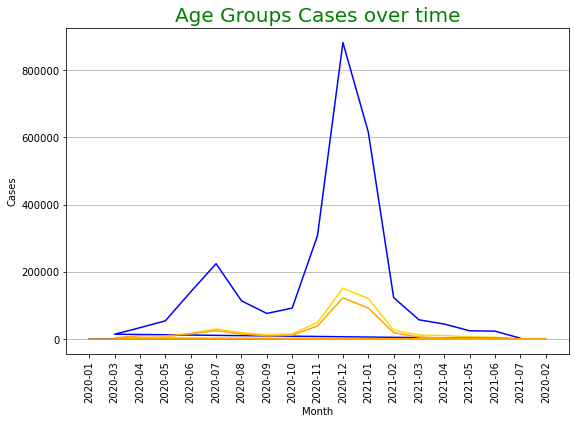

In [106]:
# Plot monthly count of infections per age group (0-17)
plt.figure(figsize=(9,6))
plt.plot(cases_0_17_df.index, cases_0_17_df["age_group"], color="gold")
plt.plot(cases_18_64_df.index, cases_18_64_df["age_group"], color="blue")
plt.plot(cases_65_up_df.index, cases_65_up_df["age_group"], color="orange")
plt.title("Age Groups Cases over time", color="green", fontsize=20)
plt.xticks(rotation="vertical")
plt.xlabel("Month")
plt.ylabel("Cases")
plt.grid(axis="y")
plt.savefig(f"{output_images}/age_group_0_17_counts.png")
plt.show()

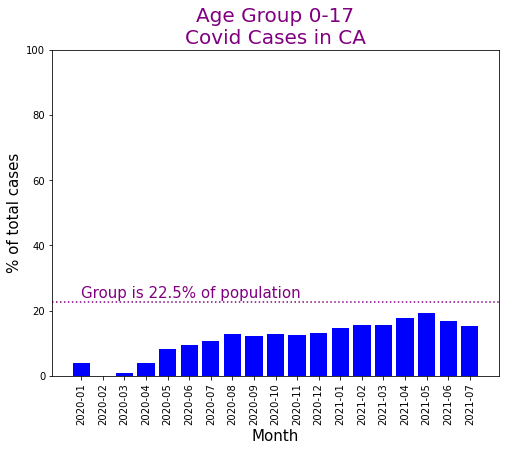

In [182]:
# Plot monthly percentage of total infections for 0-17
plt.figure(figsize=(8,6))
plt.bar(pct_monthly_0_17.index, pct_monthly_0_17["age_0_17"], color="blue")
plt.title(f"Age Group 0-17\nCovid Cases in CA", color="purple", fontsize=20)
plt.xticks(rotation="vertical")
plt.xlabel("Month", fontsize=15)
plt.ylabel("% of total cases", fontsize=15)
plt.ylim(0, 100)
plt.axhline(y = pop_pct_CA_0_17,  linestyle = ":", color="purple")
plt.annotate(f"Group is {round(pop_pct_CA_0_17,1)}% of population",(0,24),fontsize=15,color="purple")
plt.savefig(f"{output_images}/age_group_0_17_infect.png")
plt.show()

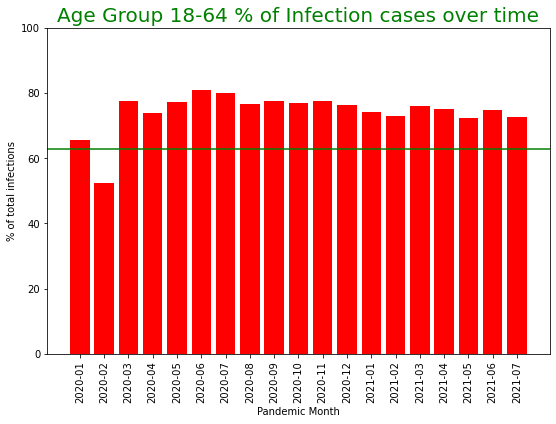

In [155]:
# Plot montly percentage of total infections for 18-64
plt.figure(figsize=(9,6))
plt.bar(pct_monthly_18_64.index, pct_monthly_18_64["age_18_64"], color="red")
plt.title("Age Group 18-64 % of Infection cases over time", color="green", fontsize=20)
plt.xticks(rotation="vertical")
plt.xlabel("Pandemic Month")
plt.ylabel("% of total infections")
plt.ylim(0, 100)
plt.axhline(y = pop_pct_CA_18_64,  color="green")
plt.savefig(f"{output_images}/age_group_18_64_infect.png")
plt.show()

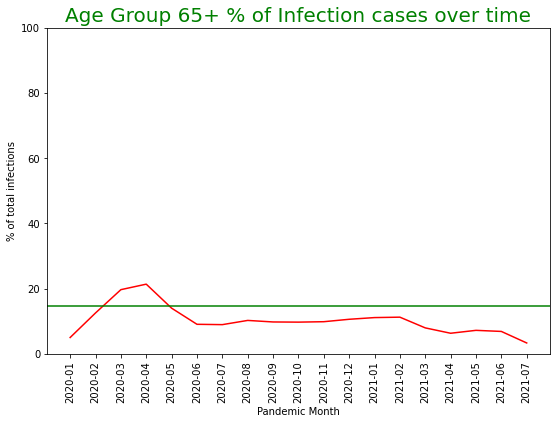

In [110]:
# Plot montly percentage of total infections for 65-up
plt.figure(figsize=(9,6))
plt.plot(pct_monthly_65_up.index, pct_monthly_65_up["age_65_up"], color="red")
plt.title("Age Group 65+ % of Infection cases over time", color="green", fontsize=20)
plt.xticks(rotation="vertical")
plt.xlabel("Pandemic Month")
plt.ylabel("% of total infections")
plt.ylim(0, 100)
plt.axhline(y = pop_pct_CA_65_up,  color="green")
plt.savefig(f"{output_images}/age_group_65_up_infect.png")
plt.show()

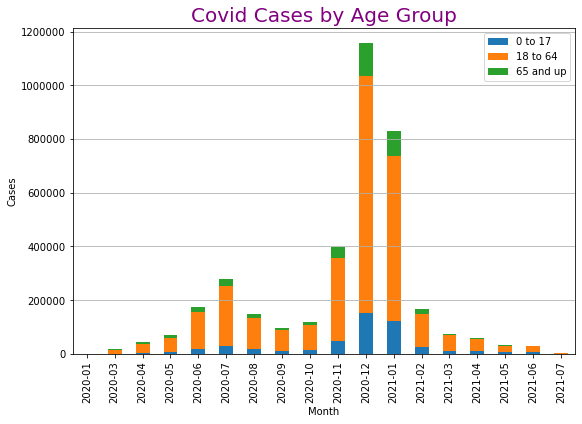

In [172]:
all_ages_cases_df.plot.bar(stacked=True, figsize=(9,6))
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.title("Covid Cases by Age Group", fontsize=20, color="purple")
plt.xlabel("Month")
plt.ylabel("Cases")
plt.grid(axis="y")
plt.savefig(f"{output_images}/age_group_total_stacked_bar.png")
plt.show()

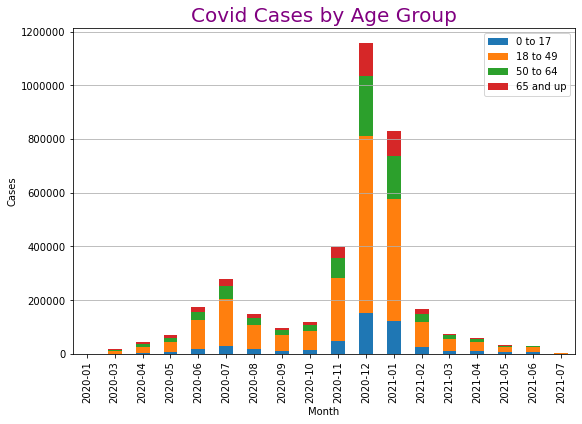

In [166]:
all_ages_2_df.plot.bar(stacked=True, figsize=(9,6))
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.title("Covid Cases by Age Group", fontsize=20, color="purple")
plt.xlabel("Month")
plt.ylabel("Cases")
plt.grid(axis="y")
plt.savefig(f"{output_images}/age_group_total_stacked_bar_4.png")
plt.show()

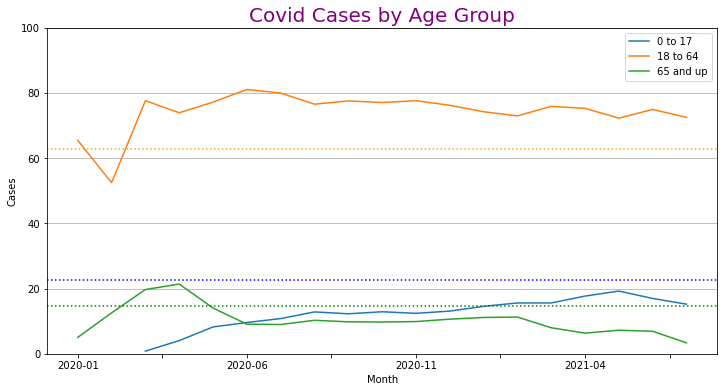

In [154]:
all_ages_pct_df.plot.line(stacked=False, figsize=(12,6))
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.title("Covid Cases by Age Group", fontsize=20, color="purple")
plt.xlabel("Month")
plt.ylim(0,100)
plt.ylabel("Cases")
plt.grid(axis="y")
plt.axhline(y = pop_pct_CA_0_17,   linestyle=":", color="blue")
plt.axhline(y = pop_pct_CA_18_64,  linestyle=":", color="orange")
plt.axhline(y = pop_pct_CA_65_up,  linestyle=":", color="green")
plt.savefig(f"{output_images}/age_group_4.png")
plt.show()